In [1]:
from time import perf_counter

import metrics as M
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from scipy.stats import cumfreq

In [2]:
def show3D(matrix, size=(8, 8)):
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    verts, faces, _, _ = measure.marching_cubes(matrix.astype(np.uint8), level=0)
    plt.close("all")
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(projection="3d")
    ax.plot_trisurf(verts[:, 0], verts[:, 2], faces, verts[:, 1])

    zdim, ydim, xdim = matrix.shape
    ax.set_xlim(0, zdim)
    ax.set_ylim(0, ydim)
    ax.set_zlim(0, xdim)
    ax.invert_zaxis()
    ax.set_box_aspect(matrix.shape)

    plt.show()

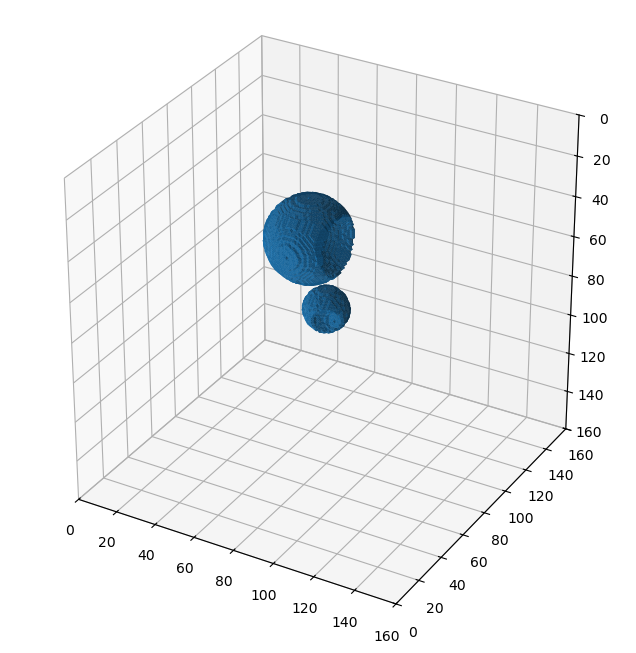

In [3]:
DIM = 160


def create_concave_sphere(radius, center, dentOffset, dentRadius, size=DIM):
    center = np.array(center)
    dentCenter = center + np.array(dentOffset)

    x, y, z = np.ogrid[:size, :size, :size]

    dist = (x - center[0]) ** 2 + (y - center[1]) ** 2 + (z - center[2]) ** 2
    dent = (x - dentCenter[0]) ** 2 + (y - dentCenter[1]) ** 2 + (z - dentCenter[2]) ** 2

    return (dist <= radius**2) & ~(dent <= dentRadius**2)


m0 = create_concave_sphere(10, (80, 80, 80), (6, 3, -10), 8)
m1 = create_concave_sphere(20, (60, 60, 100), (20, 0, 0), 15)

show3D(m0 | m1)

# Volumetric / Surface Area Analysis

In [4]:
m0_vol = M.getVolume(m0)
m1_vol = M.getVolume(m1)

m0_s = M.getSurface(m0)
m1_s = M.getSurface(m1)

m0_sa = M.getSurfaceArea(m0)
m1_sa = M.getSurfaceArea(m1)

m0_pt = np.where(m0)
m1_pt = np.where(m1)

m0m1_volDiff = M.getVolumeDiff(m0, m1)
m0m1_saDiff = M.getSurfaceAreaDiff(m0, m1)

print(f"Mask 0 to 1 Volume Difference: {m0m1_volDiff}")
print(f"Mask 0 to 1 Surface Area Difference: {m0m1_saDiff}")

Mask 0 to 1 Volume Difference: -24599
Mask 0 to 1 Surface Area Difference: -3135


# Rigid Registration / Alignment Analysis

Mask 1 to 0 Translation Vector: [ 21.88981105  19.79743453 -19.32308926]
Mask 1 to 0 Center of Mass Distance: 35.27724507485696


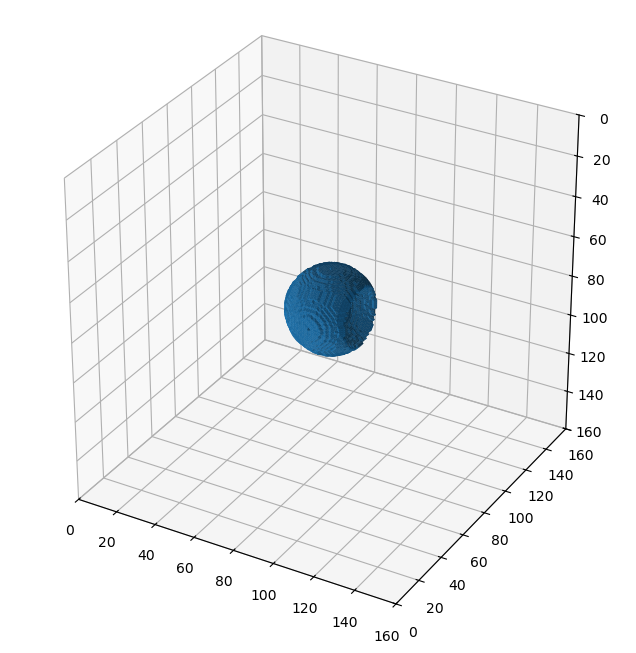

In [5]:
m1m0_transVec = M.getTranslationVector(m1, m0)
print(f"Mask 1 to 0 Translation Vector: {m1m0_transVec}")
print(f"Mask 1 to 0 Center of Mass Distance: {np.linalg.norm(m1m0_transVec)}")

m1_aligned, m0_aligned = M.rigidAlign(m1, m0, m1m0_transVec)
show3D(m0_aligned | m1_aligned)

# Margin Dilation Analysis

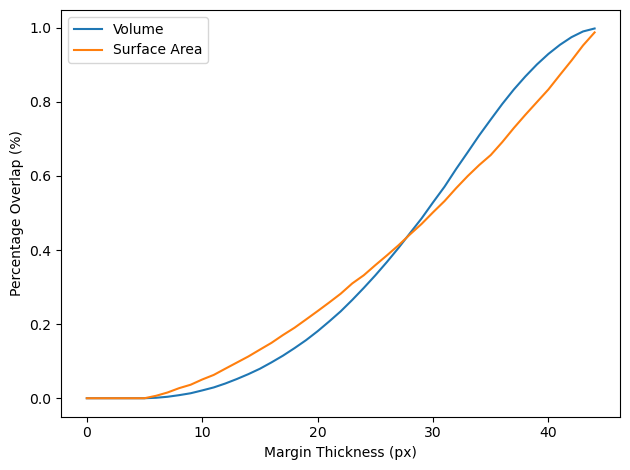

In [12]:
m0_dmap, m1_dmap = M.getDMap(m0), M.getDMap(m1)

m0_sd = m1_dmap[np.where(m0)]
m1_sd = m0_dmap[np.where(m1)]

m0_hsd = m1_dmap[np.where(m0_s)]
m1_hsd = m0_dmap[np.where(m1_s)]

vol = []
sa = []
for i in range(np.ceil(np.max(m1_sd)).astype(int)):
    vol.append(np.sum(m1_sd < i) / m1_vol)
    sa.append(np.sum(m1_hsd < i) / m1_sa)

plt.plot(vol, label="Volume")
plt.plot(sa, label="Surface Area")
plt.legend()
plt.xlabel("Margin Thickness (px)")
plt.ylabel("Percentage Overlap (%)")
plt.tight_layout()

# Surface Distance Analysis

In [15]:
m0_sd_analysis, lbl = M.seriesAnalysis(m0_sd, labels=True)
m1_sd_analysis = M.seriesAnalysis(m1_sd)

for m0V, m1V, l in zip(m0_sd_analysis, m1_sd_analysis, lbl):
    print(f"Mask0 {l} Surface Distance: {m0V:.3f}")
    print(f"Mask1 {l} Surface Distance: {m1V:.3f}\n")

Mask0 MIN Surface Distance: 5.196
Mask1 MIN Surface Distance: 5.196

Mask0 P05 Surface Distance: 7.681
Mask1 P05 Surface Distance: 12.845

Mask0 P10 Surface Distance: 9.000
Mask1 P10 Surface Distance: 16.155

Mask0 AVG Surface Distance: 14.695
Mask1 AVG Surface Distance: 28.342

Mask0 MDN Surface Distance: 15.000
Mask1 MDN Surface Distance: 29.343

Mask0 P90 Surface Distance: 19.950
Mask1 P90 Surface Distance: 38.923

Mask0 P95 Surface Distance: 21.119
Mask1 P95 Surface Distance: 40.755

Mask0 MAX Surface Distance: 24.249
Mask1 MAX Surface Distance: 44.508



Time taken to compute surfaces: 11.046

Mask0 Facing Surface Percentage: 61.593%
Mask1 Facing Surface Percentage: 37.676%



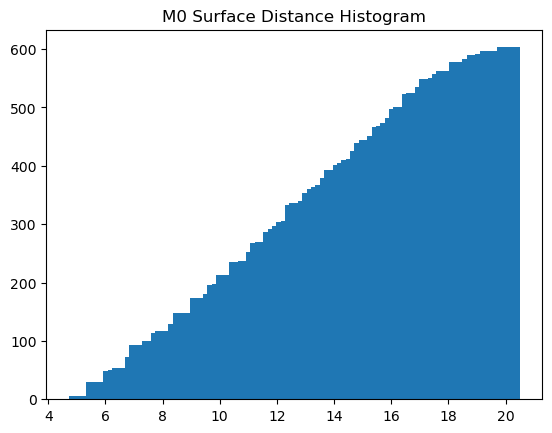

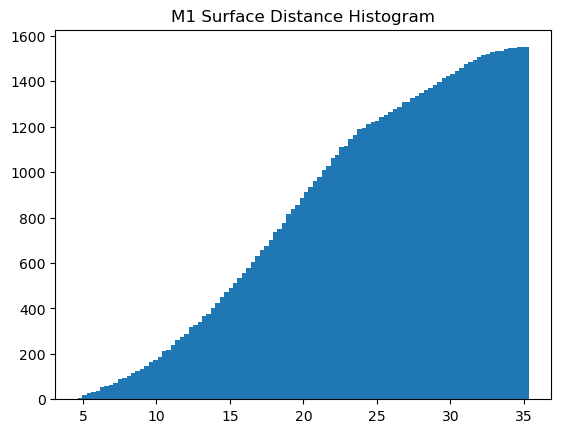

Mask0 MIN Facing Surface Distance: 5.196
Mask1 MIN Facing Surface Distance: 5.196

Mask0 P05 Facing Surface Distance: 6.403
Mask1 P05 Facing Surface Distance: 7.810

Mask0 P10 Facing Surface Distance: 7.071
Mask1 P10 Facing Surface Distance: 9.950

Mask0 AVG Facing Surface Distance: 12.333
Mask1 AVG Facing Surface Distance: 19.228

Mask0 MDN Facing Surface Distance: 12.450
Mask1 MDN Facing Surface Distance: 19.079

Mask0 P90 Facing Surface Distance: 17.349
Mask1 P90 Facing Surface Distance: 29.535

Mask0 P95 Facing Surface Distance: 18.385
Mask1 P95 Facing Surface Distance: 31.273

Mask0 MAX Facing Surface Distance: 20.025
Mask1 MAX Facing Surface Distance: 34.771



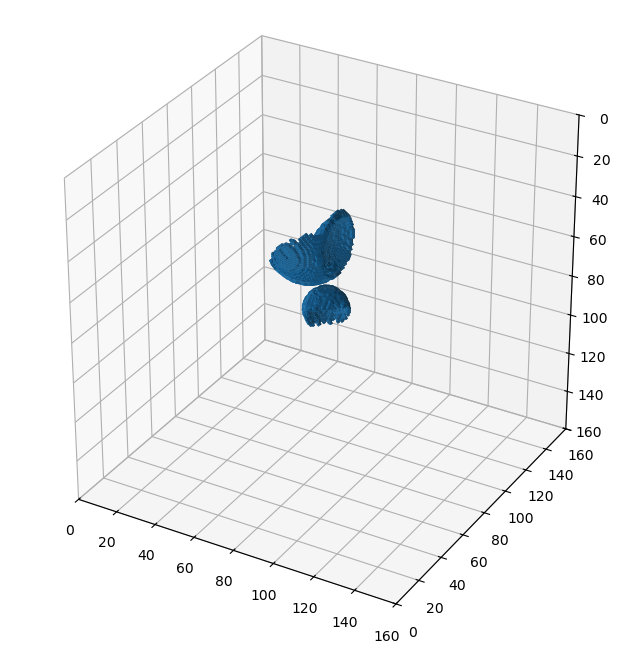

In [9]:
t0 = perf_counter()
m0_fs, m1_fs = M.getFacingSurfaces(m0, m1)
print(f"Time taken to compute surfaces: {(perf_counter() - t0):.3f}\n")

m0_fsp, m1_fsp = M.getFacingSurfacePercentage(m0, m1, facingS=m0_fs, facingT=m1_fs)

print(f"Mask0 Facing Surface Percentage: {(m0_fsp * 100):.3f}%")
print(f"Mask1 Facing Surface Percentage: {(m1_fsp * 100):.3f}%\n")

m0_fsd, m1_fsd = M.getFacingSurfaceDistance(m0, m1, m0_dmap, m1_dmap, facingS=m0_fs, facingT=m1_fs)

m0_fsd_analysis, lbl = M.seriesAnalysis(m0_fsd, labels=True)
m1_fsd_analysis = M.seriesAnalysis(m1_fsd)

m0Res = cumfreq(m0_fsd, numbins=100)
m0X = m0Res.lowerlimit + np.linspace(0, m0Res.binsize * m0Res.cumcount.size, m0Res.cumcount.size)

m1Res = cumfreq(m1_fsd, numbins=100)
m1X = m1Res.lowerlimit + np.linspace(0, m1Res.binsize * m1Res.cumcount.size, m1Res.cumcount.size)

plt.figure()
plt.title("M0 Surface Distance Histogram")
plt.bar(m0X, m0Res.cumcount)
plt.show()

plt.figure()
plt.title("M1 Surface Distance Histogram")
plt.bar(m1X, m1Res.cumcount)
plt.show()


for m0V, m1V, l in zip(m0_fsd_analysis, m1_fsd_analysis, lbl):
    print(f"Mask0 {l} Facing Surface Distance: {m0V:.3f}")
    print(f"Mask1 {l} Facing Surface Distance: {m1V:.3f}\n")

show3D(m0_fs | m1_fs)